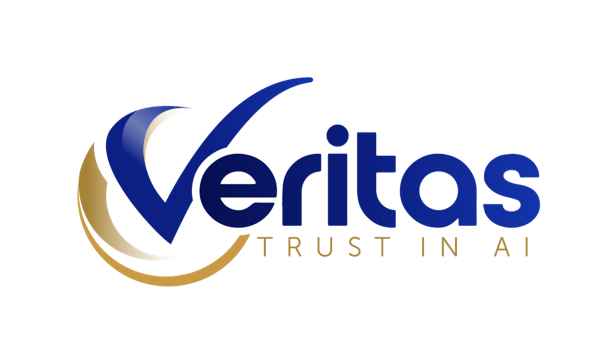

# Veritas Demo: Customer Marketing Uplift Model 

<p>   
    The <b>Veritas toolkit</b> is comprised of diagnosis tool and assessment tool.
    This scenario is to build a customer marketing model and use diagnosis tool to evaluate model & produce
    the model artifact required by assessment tool to generate the fairness & transparency assessment report.
</p> 
<p>    
    Uplift model includes two models: product propensity model and rejection model. <br/>
    Both of the included models are multi-class classification models. <br/>
    Steps to perform: <br/>
    1. Loading Data and Model <br/>  
    2. Fairness & Transparency Diagnosis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.1 compute performance and fairness metrics <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.2 compute trade off analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.3 compute feature importance analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.4 compute transparency analysis <br/>
    &nbsp;&nbsp;&nbsp;&nbsp;2.5 save results in json artifact <br/>
</p>

# 1. Load Customer Marketing Uplift Data & Model

## Importing Libraries 

In [1]:
%load_ext autoreload
%autoreload 2
import sys

# making veritas available in search path
sys.path.append("../../../")
import pickle
import numpy as np
import pandas as pd
import os

## Loading Data 

Dataset used is generated from : https://github.com/veritas-project/phase1/tree/main/customer_marketing  

In [2]:
pth = "../../../../../user_defined_files"
# For dataset used for rejection model and propensity model, the feature data are same only the labels are different.

# Load Phase 1-Customer Marketing Uplift Model Data, Results and Related Functions
file_prop = os.path.join(pth, "veritas_data", "mktg_uplift_acq_dict.pickle")
file_rej = os.path.join(pth, "veritas_data", "mktg_uplift_rej_dict.pickle")
input_prop = open(file_prop, "rb")
input_rej = open(file_rej, "rb")
cm_prop = pickle.load(input_prop)
cm_rej = pickle.load(input_rej)

# Model Container Parameters

# Rejection Model
y_true_rej = cm_rej["y_test"]
y_pred_rej = cm_rej["y_test"]
y_train_rej = cm_rej["y_train"]
p_grp_rej = {"isforeign": [0], "isfemale": [0], "isforeign|isfemale": "maj_rest"}
x_train_rej = cm_rej["X_train"].drop(["ID"], axis=1)
x_test_rej = cm_rej["X_test"].drop(["ID"], axis=1)
y_prob_rej = pd.DataFrame(cm_rej["y_prob"], columns=["CN", "CR", "TN", "TR"])
data = {
    "FEATURE": ["income", "noproducts", "didrespond", "age", "isfemale", "isforeign"],
    "VALUE": [0.3, 0.2, 0.15, 0.1, 0.05, 0.03],
}


# Propensity Model
y_true_prop = cm_prop["y_test"]
y_pred_prop = cm_prop["y_test"]
y_train_prop = cm_prop["y_train"]
y_prob_prop = pd.DataFrame(cm_prop["y_prob"], columns=["CN", "CR", "TN", "TR"])


PROFIT_RESPOND = 190
COST_TREATMENT = 20

## Loading Model

In [3]:
model_object_rej = cm_rej["model"]
model_name_rej = "custmr_marketing"
model_type_rej = "uplift"
model_object_prop = cm_prop["model"]
model_type_prop = "uplift"

# fit the models as it's a pre-requisite for transparency analysis
model_object_rej.fit(x_train_rej, y_train_rej)
model_object_prop.fit(x_train_rej, y_train_prop)

/Users/timlrx/Documents/aiverify/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/timlrx/Documents/aiverify/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Uplifter(clf=Pipeline(steps=[('standardscaler', StandardScaler()),
                             ('logisticregression',
                              LogisticRegression(multi_class='multinomial'))]),
         liftfn=<function multiclass_lift at 0x1037ef640>,
         selectionfn=functools.partial(<function threshold at 0x127ede050>, thresh=0.0))

# 2. Fairness & Transparency Diagnosis

## Import Veritas Library

Veritas Library use case object creation includes two step. In the first step, Model_Container object is created with generic machine learning inputs. In the second step, use case object is created with Model_Container object and use case specific inputs. Customer Marketing is showcased in this notebook.

In [4]:
from aiverify_veritastool.model.model_container import ModelContainer
from aiverify_veritastool.usecases.customer_marketing import CustomerMarketing

## Initializing Veritas Library

In [5]:
# Create Model Containers
container_rej = ModelContainer(
    y_true=y_true_rej,
    y_pred=y_pred_rej,
    y_prob=y_prob_rej,
    y_train=y_train_rej,
    p_grp=p_grp_rej,
    x_train=x_train_rej,
    x_test=x_test_rej,
    model_object=model_object_rej,
    model_name=model_name_rej,
    model_type=model_type_rej,
    pos_label=["TR", "CR"],
    neg_label=["TN", "CN"],
)

container_prop = container_rej.clone(
    y_true=y_true_prop,
    y_pred=y_pred_prop,
    y_prob=y_prob_prop,
    y_train=y_train_prop,
    model_object=model_object_prop,
    pos_label=["TR", "CR"],
    neg_label=["TN", "CN"],
)

| Var Name    | Category       |Sub-category   | Description   |  Value        |
| :---        |    :----:      |   :----:      |          ---: |          ---: |
| y_true      | data           | testing       | test set labels| array([0, 1, 1, ..., 1])   |
| p_var       | protected vars |    -          | list of protected vars| [ 'SEX', 'MARRIAGE' ]      |
| p_grp       | protected vars |    -          | list of privileged groups| { 'SEX': [ 1 ] , 'MARRIAGE': [ 1 ] }   |
| model_type  | others         |    -          | type of model | 'default'    |
| model_name  | others         |    -          | name of model | 'uplift'   |
| y_pred      | data           | testing       | test set predicted labels | array([0, 1, 1, ..., 1])   |
| y_prob      | data           | testing       | test set predicted probabilities | array([0.56, 0.33, 0.11, ..., 0.98])   |
| y_train     | data           | training      | train set labels      | array([0, 1, 1, ..., 1])   |
| x_train     | data           | training      | train set features |-      |
| x_test      | data           | testing       | test set features | -      |
| model_obj   | model          |    -          | model to assess| -      |

<h5 align="center">Table 1: Model Container parameters   </h5>

In [6]:
# Create Use Case Object
cm_uplift_obj = CustomerMarketing(
    model_params=[container_rej, container_prop],
    fair_threshold=80,
    fair_concern="eligible",
    fair_priority="benefit",
    fair_impact="significant",
    perf_metric_name="expected_profit",
    fair_metric_name="auto",
    revenue=PROFIT_RESPOND,
    treatment_cost=COST_TREATMENT,
    tran_row_num=[20, 40],
    tran_max_sample=1000,
    tran_pdp_feature=["age", "income"],
    tran_pdp_target="CR",
)

<h5 align="center">Table 2: Customer Marketing parameters   </h5>

| Var Name    | Category       | Description   |  Value        |Compulsory|
| :---        |    :----:      |          ---: |          ---: |---:|
| model_params| model containers | list of model containers | -  |Yes|
| fair_threshold | fairness metric thresolding |threshold used for assessment|floating value between 0 and 1 (treated as actual <br/> value) or 1 and 100 (treated as p%)   |No|
| fair_concern |fair_metric selection| for auto-suggestion: most concerned cohort| "eligible" or "inclusive" or "both" |No|
| fair_priority| fair_metric selection| for auto-suggestion: top priority to be for fairness assessment | "benefit" or "harm" |No|
| fair_impact  | fair_metric selection | for auto-suggestion: impact magnitude and type | "normal" or "significant" or "selective"   |No|
| fair_metric_type  | fair_metric selection | for auto-suggestion: type of metric | "difference" or "ratio"  |No|
| fair_metric_name      | metric name |primary fairness metric | "auto" or any of supported ones <br/> like "expected_harm"   |No|
| perf_metric_name      | metric name |primary performance metric |"expected_profit"   |Yes|
| tran_row_num      | transparency parameter |row number for local interpretability plot starting with 1 |list of integers   |No|
| tran_max_sample      | transparency parameter |sampling size for transparency analysis |float value between 0 and 1 (treated as <br/> percentage of rows)  or  int treated as #rows   |No|
| tran_pdp_feature      | transparency parameter |feature list for pdp plots |list of features   |No|
| tran_pdp_target      | transparency parameter |class label for pdp plots(required for multi-class model) |string |No|
| tran_max_display      | transparency parameter |#features to be displayed in the transparency plots |int    |No|
| tran_processed_data      | transparency parameter |sample dataframe for the analysis incase x_train is a string |dataframe    |No|
| tran_processed_label      | transparency parameter |list of y_train(s) for the given tran_processed_data |list    |No|






## Starting Fairness diagnosis

In [7]:
cm_uplift_obj.evaluate()

Evaluate performance:   0%|          

y_true_counts columns: Index(['proportion'], dtype='object')
y_true_counts:
        proportion
index            
CN         0.3734
TN         0.2476
CR         0.2277
TR         0.1513

Special Parameters
Revenue         | Treatment Cost  
----------------------------------
190             | 20              


Class Distribution
	CN                                                                 37.340%
	TN                                                                 24.760%
	CR                                                                 22.770%
	TR                                                                 15.130%


Performance Metrics
	Empirical Lift                                             0.158 +/- 0.025
	Expected Profit Lift                                74658.798 +/- 5605.930
	Expected Selection Rate                                    0.504 +/- 0.010


Primary Fairness Metric Suggestion
	Harm from Rejection
based on
	fair_priority = benefit
	fair_concern = eligibl

In [8]:
cm_uplift_obj.evaluate(visualize=True, output=True)

In [9]:
cm_uplift_obj.tradeoff()

Tradeoff:   0%|          


----------------------------- 1. isforeign -----------------------------
Performance versus Fairness Trade-Off
	 Single Threshold
		Privileged/Unprivileged Threshold                 0.111
		Best expected_profit*                         92710.373
	 Separated Thresholds
		Privileged Threshold                              0.217
		Unprivileged Threshold                            0.331
		Best expected_profit*                         96369.029
	 Separated Thresholds under Neutral Fairness (0.001)
		Privileged Threshold                              0.217
		Unprivileged Threshold                            0.331
		Best expected_profit*                         96369.029
		*estimated by approximation, subject to the resolution of mesh grid

----------------------------- 2. isfemale  -----------------------------
Performance versus Fairness Trade-Off
	 Single Threshold
		Privileged/Unprivileged Threshold                 0.160
		Best expected_profit*                         92299.226
	 Separated

<h5 align="center">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Table 3: Use of protected variable in model</h5>

|Fairness|Performace|Suggestion|
| -------- | ---------- | --------------- |
|Worse  |Worse	|Include|
|Better|Better|Exclude|
|Worse|Better|Examine Further|
|Better|Worse|Examine Further|

In [10]:
cm_uplift_obj.feature_importance()

Feature importance:   0%|          

/Users/timlrx/Documents/aiverify/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/timlrx/Documents/aiverify/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/timlrx/Documents/aiverify/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/timlrx/Documents/aiverify/.venv/lib/python3.10/site-pa




--------------------------------------------------1: Fairness on Isfemale---------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------
|Removed Protected Variable    |expected_profit          |rejected_harm            |Fairness Conclusion |Suggestion        |
----------------------------------------------------------------------------------------------------------------------------
|isfemale                      |640780.322               |-0.120                   |unfair to unfair (-)|Examine Further   |
----------------------------------------------------------------------------------------------------------------------------
|isforeign                     |645340.683               |-0.140                   |unfair to unfair (-)|Examine Further   |
-------------------------------------------------------------------------------------------------------------------------

Correlation analysis :   0%|          


Partial correlation matrix (Most correlated features for isfemale, isforeign):


,isfemale,isforeign,noproducts,income,age
isfemale,1.000000,0.022928,0.172496,0.467237,0.037134
isforeign,0.022928,1.000000,0.089294,0.272970,0.292067
noproducts,0.172496,0.089294,1.000000,0.448823,0.000000
income,0.467237,0.272970,0.448823,1.000000,0.031726
age,0.037134,0.292067,0.000000,0.031726,1.000000


* No surrogate detected based on correlation analysis (threshold=0.7).


Root cause analysis:   0%|          



                              Top 10 contributors towards bias for class 'TR'     
                         Measured by SHAP-based Demographic Parity on 1002 samples




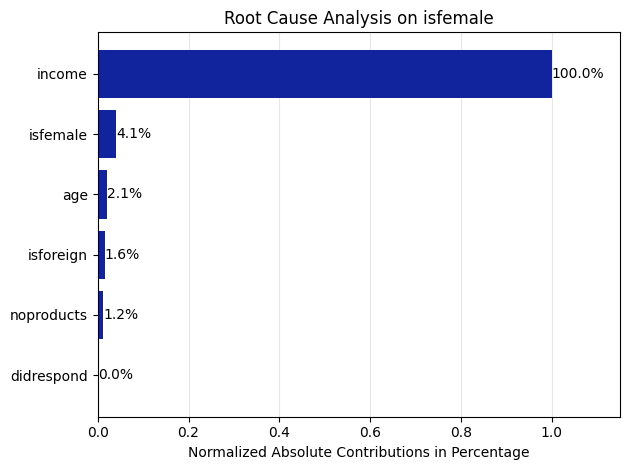

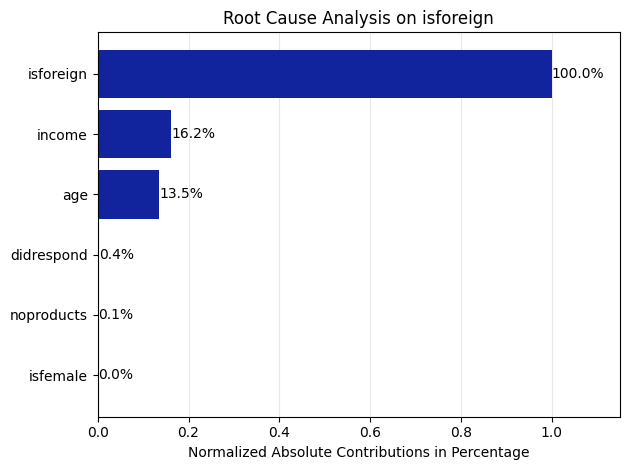

In [11]:
cm_uplift_obj.rootcause(p_var=[])

In [12]:
mitigated = cm_uplift_obj.mitigate(p_var=[], method=["reweigh", "correlate"])

Bias mitigation :   0%|          


*Effective input for p_var = ['isfemale', 'isforeign']

                                   Reweighing                                   

--------------------------------------------------------------------------------
|isfemale, isforeign           |Label                  |Weight                 |
--------------------------------------------------------------------------------
|0, 0                          |CN                     |0.976                  |
--------------------------------------------------------------------------------
|0, 0                          |CR                     |1.448                  |
--------------------------------------------------------------------------------
|0, 0                          |TN                     |0.989                  |
--------------------------------------------------------------------------------
|0, 0                          |TR                     |1.228                  |
---------------------------------------------------

In [13]:
# sample_weights can be used to reinitialise the model container and rerun fairness assessment
sample_weights_mitigated = mitigated["reweigh"][0]

In [14]:
# x_train, x_test can be used to reinitialise the model container and rerun fairness assessment
# Skipped in this demo as there are no surrogates detected
# x_train_mitigated = mitigated['correlate'][0]
# x_test_mitigated = mitigated['correlate'][1]

New dataset can be transformed with the calculated group weights as follows.

In [15]:
# for illustration, a new dataset is being sampled from x_test and y_true
indices = np.random.choice(x_test_rej.index, size=50, replace=False)
x_test_sample = x_test_rej.loc[indices].reset_index(drop=True)
y_true_sample = y_true_rej.values[indices]
group_weights = mitigated["reweigh"][1]

In [16]:
transform_mitigated = cm_uplift_obj.mitigate(
    method=["reweigh"], rw_weights=group_weights, transform_x=x_test_sample, transform_y=y_true_sample
)

Bias mitigation :   0%|          


*Effective input for p_var = ['isfemale', 'isforeign']

                                   Reweighing                                   

Calculating sample_weights for transform_x based on provided rw_weights,
transform_y.



In [17]:
# sample weights for new dataset
transform_mitigated["reweigh"]

array([1.0903879 , 0.98850261, 0.97575389, 0.97575389, 0.98850261,
       0.97856992, 0.97575389, 0.9619539 , 0.9619539 , 0.97856992,
       0.9619539 , 0.97856992, 1.0903879 , 1.05763338, 1.0903879 ,
       0.97575389, 1.05763338, 1.05763338, 1.05442423, 0.97575389,
       0.97575389, 0.97575389, 0.98850261, 0.97575389, 0.97856992,
       0.98850261, 0.9619539 , 0.9619539 , 1.0903879 , 0.97575389,
       1.0085577 , 1.0085577 , 0.98850261, 0.97575389, 1.0903879 ,
       0.98850261, 0.97856992, 0.97575389, 0.97575389, 1.0903879 ,
       1.0903879 , 0.9619539 , 0.9619539 , 0.64978732, 0.9619539 ,
       0.98850261, 0.97575389, 0.97575389, 0.9619539 , 1.05442423])

## Starting Transparency Diagnosis

Running transparency for model 2        done      
     Data preparation                   done      
     Interpretability                   done      
     Partial dependence                 done      


Computing Permutation Importance:   0%|          

     Permutation importance             done      


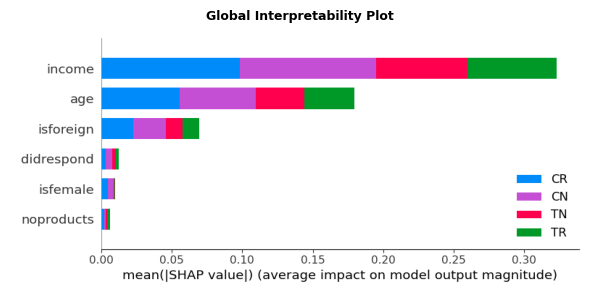

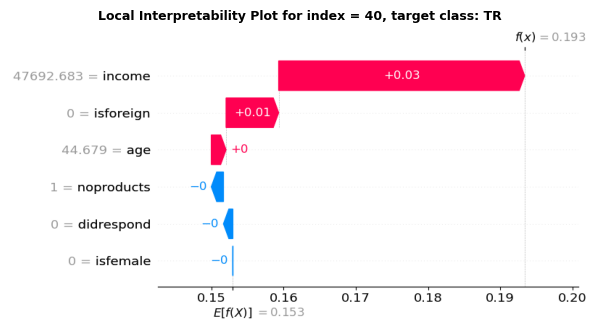

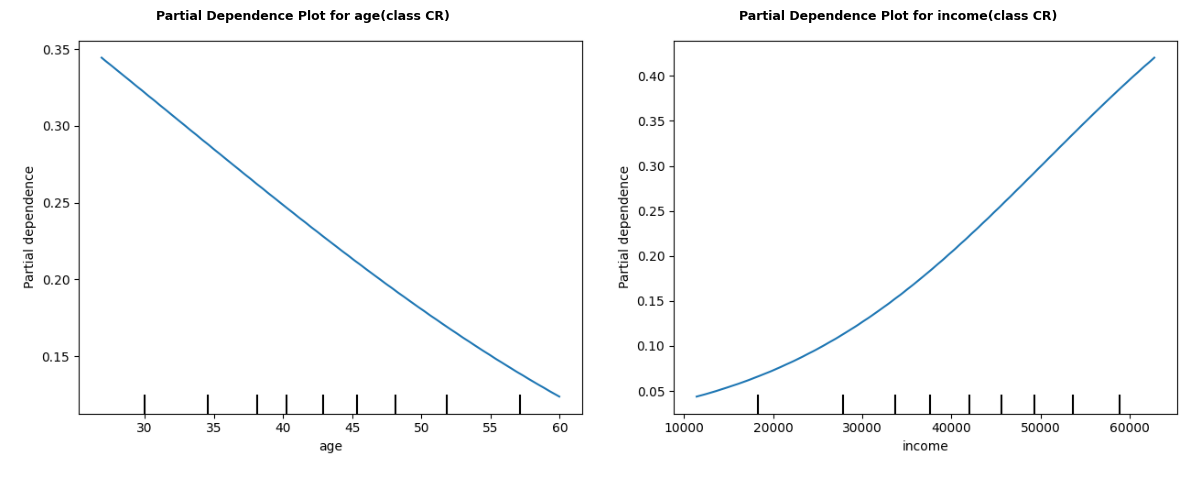

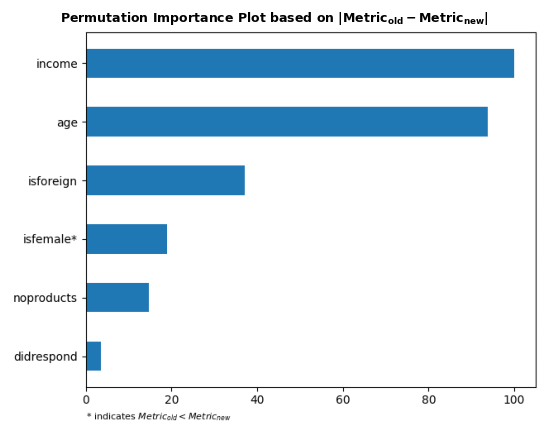

In [18]:
# run the entire transparency analysis for the required model
cm_uplift_obj.explain(model_num=2)

<h5 align="center">Table 3: Transparency parameters   </h5>

| Var Name    | Description   |  Value        |Default|Compulsory|
| :---        |          ---: |          ---: |---:|---:|
| disable | disable any of the transparency analysis |list of valid inputs ['interpret','partial_dep','perm_imp']  |blank list |No|
| local_row_num |row number for local interpretability plot |integer   |last value of tran_row_num |No|
| model_num   |model for which assessment is required |1 or 2   |last model in model container |No|
| output      |boolean value for displaying the plots |True or False   |True |No|





     Interpretability                   done      


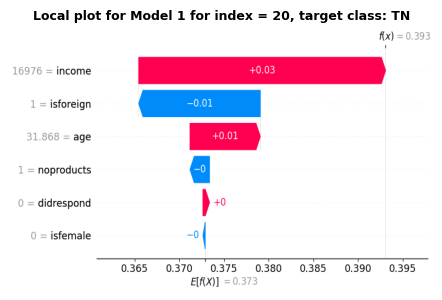

In [19]:
# get the local interpretability plot for specific row index and model
cm_uplift_obj.explain(local_row_num=20, model_num=1)

## Compiling Results

In [20]:
# Previous Veritas way to compile fairness and transparency diagnosis results
# cm_uplift_obj.compile()

# We can now assign the output to a variable and convert it into an AI Verify testing output
from aiverify_veritastool.util.aiverify import convert_veritas_artifact_to_aiverify

output = cm_uplift_obj.compile(save_artifact=False)
convert_veritas_artifact_to_aiverify(model_artifact=output, output_dir="output")

Running evaluate                        done      
     performance measures               done      
     bias detection                     done      
     probability calibration            skipped   
     performance dynamics               done      
     individual fairness                skipped   
Running tradeoff                        done      
Running feature importance              done      
     leave-one-out analysis             done      
     correlation analysis               done      
Running transparency for model 1        done      
     Partial dependence                 done      


Computing Permutation Importance:   0%|          

     Permutation importance             done      
Running transparency for model 2        done      
Generating model artifact               

/Users/timlrx/Documents/aiverify/.venv/lib/python3.10/site-packages/aiverify_veritastool/util/aiverify.py:327: UserWarning: ground_truth key is missing
  warnings.warn(f"{key} key is missing")
/Users/timlrx/Documents/aiverify/.venv/lib/python3.10/site-packages/aiverify_veritastool/util/aiverify.py:327: UserWarning: data_path key is missing
  warnings.warn(f"{key} key is missing")
/Users/timlrx/Documents/aiverify/.venv/lib/python3.10/site-packages/aiverify_veritastool/util/aiverify.py:327: UserWarning: ground_truth_path key is missing
  warnings.warn(f"{key} key is missing")
